<a href="https://colab.research.google.com/github/miguel-fc/Neutron_Reflect/blob/main/nr_v15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/miguel-fc/Neutron_Reflect.git

Cloning into 'Neutron_Reflect'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 163 (delta 23), reused 39 (delta 10), pack-reused 106
Receiving objects: 100% (163/163), 15.01 MiB | 30.38 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [2]:
# Import Python related required packages
import io
import os
import cv2
import gdown
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import pickle

#Import torch related packages
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
#Set these important parameters
#Dimension of the latent space 
d = 3
#Dimension of the graphs
in_d1 = 2
in_d2 = 72
#Number of epochs
num_epochs = 1000
#Number of layers
num_layers = 3
#Number of neurons
num_neur=500 


In [4]:
cd Neutron_Reflect/

/content/Neutron_Reflect


In [5]:
#Stored those numpy arrays
data_path = './data/'
expt_arr = np.load(os.path.join(data_path,'mod_expt.npy'))
# expt_arr_o = np.loadtxt(os.path.join(data_path,'flipped_sorted_no_nano_expt.dat')).T
# expt_arr = np.zeros_like(expt_arr_o)
# # expt_arr[0] = 1791.5076453352374 - expt_arr_o[0]
# expt_arr[0] = expt_arr_o[0]
# expt_arr[1] = expt_arr_o[1]
sld_arr = np.load(os.path.join(data_path,'mod_sld_fp49.npy'))
params_arr = np.load(os.path.join(data_path,'mod_params_fp49.npy'))
# t_sld_arr = np.load(os.path.join(data_path,'train_data.npy'))
# params_arr = np.load(os.path.join(data_path,'train_pars.npy'))

In [6]:
expt_arr.shape ,sld_arr.shape, params_arr.shape, sld_arr.dtype, params_arr.dtype, expt_arr.dtype

((2, 72),
 (5942, 2, 72),
 (5942, 3),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'))

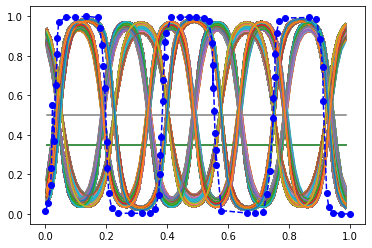

In [7]:
for x in range(sld_arr.shape[0]):
  plt.plot(sld_arr[x][0],sld_arr[x][1])
plt.plot(expt_arr[0],expt_arr[1],'bo',linestyle='dashed')

In [8]:
#Import packages from the github clone
import data_preparation as dpre
import AutoEnc as au
import MLP as mlp

In [9]:
#Prepare data files
xtrain, ytrain, xval, yval, xtest, ytest = \
dpre.split_input_arrays(sld_arr,params_arr, size_split=0.8)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(4753, 2, 72) (4753, 3) (594, 2, 72) (594, 3) (595, 2, 72) (595, 3)


In [10]:
#Prepare data files, continuation
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=50)

In [11]:
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [12]:
def initialize_model(d,in_d1,in_d2,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  encoder = au.Encoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)
  decoder = au.Decoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': encoder.parameters()},
     {'params': decoder.parameters()}
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return encoder, decoder, optim

In [13]:
#Initialize autoencoder
encoder, decoder, optim = initialize_model(d,in_d1,in_d2,num_layers,num_neur)

#train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = au.fit(encoder,decoder,device,train_loader,loss_fn,optim)
  val_loss = au.val(encoder,decoder,device,valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)
  # plot_ae_outputs(model,train_dataset,device,n=10)

EPOCH 1/1000 	 train loss 0.08446025848388672 	 val loss 0.06482850015163422
EPOCH 2/1000 	 train loss 0.030274322256445885 	 val loss 0.0028523372020572424
EPOCH 3/1000 	 train loss 0.0007556797354482114 	 val loss 0.000676090712659061
EPOCH 4/1000 	 train loss 0.00043709322926588356 	 val loss 0.0005159953143447638
EPOCH 5/1000 	 train loss 0.0003351511259097606 	 val loss 0.00038353700074367225
EPOCH 6/1000 	 train loss 0.0002873027406167239 	 val loss 0.00040955940494313836
EPOCH 7/1000 	 train loss 0.0002533528895583004 	 val loss 0.0002444952551741153
EPOCH 8/1000 	 train loss 0.0002809935249388218 	 val loss 0.00032001439831219614
EPOCH 9/1000 	 train loss 0.00023639104620087892 	 val loss 0.00024334591580554843
EPOCH 10/1000 	 train loss 0.00022156113118398935 	 val loss 0.0007164123235270381
EPOCH 11/1000 	 train loss 0.0002803929091896862 	 val loss 0.0002415081689832732
EPOCH 12/1000 	 train loss 0.00019814427650999278 	 val loss 0.000440418254584074
EPOCH 13/1000 	 train lo

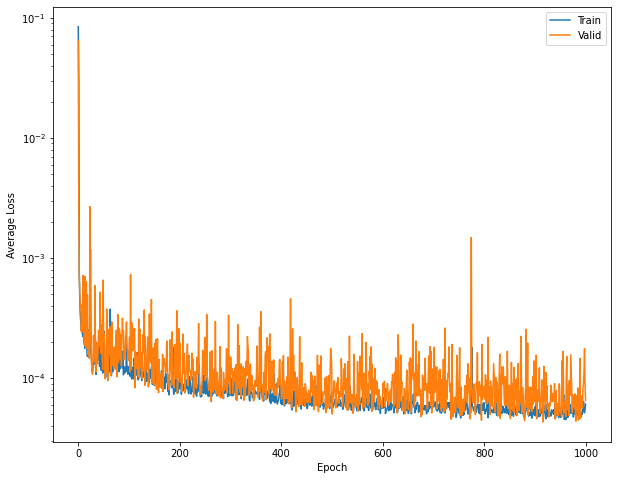

In [14]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

For image 0, the loss = 2.935460906883236e-05
For image 1, the loss = 7.409141835523769e-05
For image 2, the loss = 6.7619897890836e-05
For image 3, the loss = 4.0796923713060096e-05
For image 4, the loss = 2.345914617762901e-05
For image 5, the loss = 0.0001521512895124033
For image 6, the loss = 3.197275145794265e-05
For image 7, the loss = 7.97872562543489e-05
For image 8, the loss = 3.55733536707703e-05
For image 9, the loss = 3.1995823519537225e-05


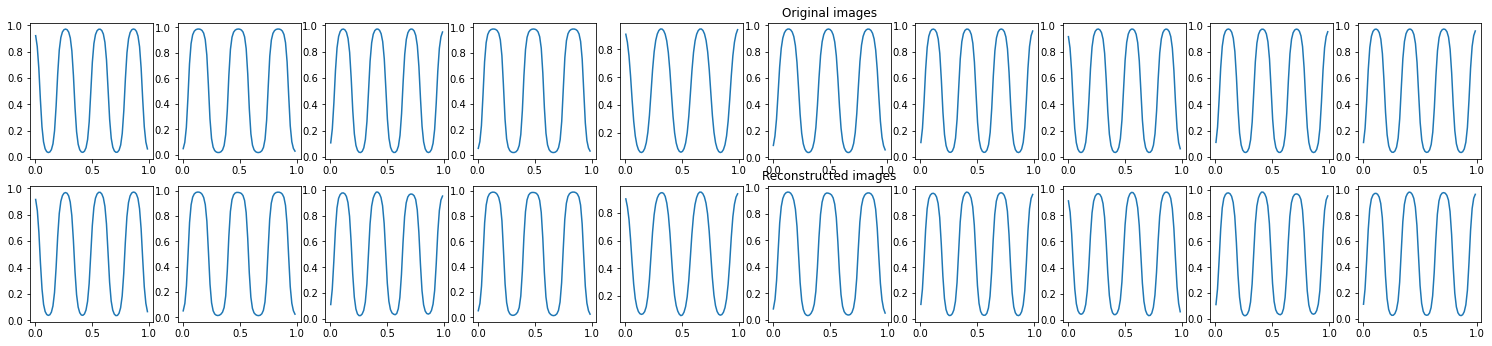

In [15]:
au.test(encoder,decoder,test_dataset,device,loss_fn,in_d1,in_d2,n=10)

tensor([-2.9760e+00, -9.0745e-01,  4.3625e-04])
tensor([2.5198e+00, 2.1030e+00, 8.7865e-04])


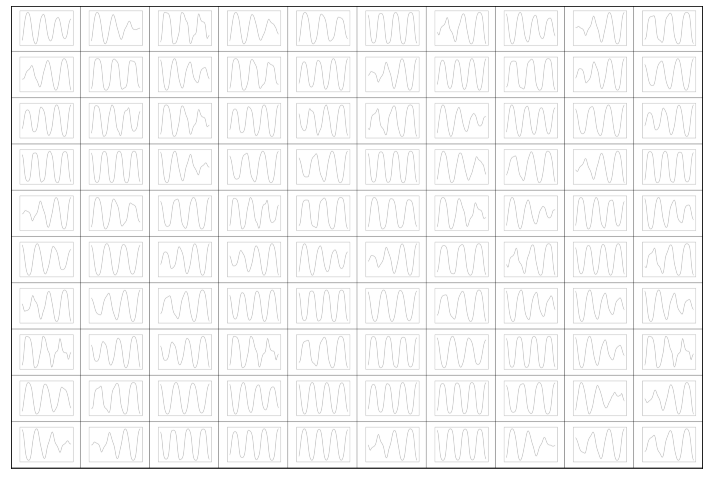

In [16]:
#Interpolating in the latent space
#This is similar to a manifold

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    plt.close()
    img = cv2.imdecode(img_arr,0)

    return img

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_xticks([])
    ax.set_yticks([])

encoder.eval()
decoder.eval()

with torch.no_grad():
    images, labels = iter(train_loader).next()
    images = images.view(images.size(0), -1).to(device) 

    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)


    latent = torch.randn(200, d)*std + mean
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.view(img_recon.size(0), in_d1,in_d2).cpu()


n_img = []
for i in range(img_recon.shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.close()
    ax.plot(img_recon[i][0],img_recon[i][1])
    n_img.append(get_img_from_fig(fig))

n_img = torch.from_numpy(np.asarray(n_img))
n_img = n_img[:,np.newaxis,:,:]

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(n_img[:100],10,5))
plt.show()

In [17]:
nlabel = params_arr.shape[1]
# nlabel

for i in range(nlabel):
  label_index = 'label'+str(i)
  # print(label_index)

In [18]:
encoded_samples = []
for sample in train_dataset:
    img = sample[0].unsqueeze(0)
    img = img.view(img.size(0), -1).to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    encoded_img = encoded_img.flatten().cpu().numpy()
    # print(enumerate(encoded_img))
    encoded_sample = {f"l{i+1}": enc for i, enc in enumerate(encoded_img)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      encoded_sample[label_index] = label_val[i].numpy()
    # encoded_sample['label1'] = label[1].numpy()
    # encoded_sample['label2'] = label[2].numpy()
    # encoded_sample['label3'] = label[3].numpy()
    encoded_samples.append(encoded_sample)
df_encoded_samples = pd.DataFrame(encoded_samples)
df_encoded_samples

,l1,l2,l3,label0,label1,label2
0,-7.055904,-1.506355,-0.001033,0.193,-0.524,-0.22836
1,-1.824063,-3.632485,0.000673,0.129,0.173,-0.41819
2,-6.919295,-1.644625,-0.000993,0.103,-0.0487,-0.20837
3,-6.993834,-1.659259,-0.001020,0.124,-0.0106,-0.15641
4,-7.043716,-1.550626,-0.001031,0.167,-0.371,-0.08402
...,...,...,...,...,...,...
4748,-0.380607,-0.009777,0.001403,0.0873,0.101,0.08388
4749,-2.184852,-3.227814,0.000572,0.0761,0.0866,-0.3034
4750,0.022057,0.090002,0.001551,0.178,0.0818,0.06908
4751,-4.724449,2.253105,0.000016,0.163,-0.559,0.1099


In [19]:
pepe = np.asarray(encoded_samples)

In [20]:
pepe.shape


(4753,)

In [21]:
#Creating dataloaders for the MLP. This includes train, valid and test

img, out_img, train_latent_var, train_labels_var = au.get_latent_variables(encoder,decoder,device,train_loader)
print(img.shape, out_img.shape, train_latent_var.shape, train_labels_var.shape)

img, out_img, valid_latent_var, valid_labels_var = au.get_latent_variables(encoder,decoder,device,valid_loader)
print(img.shape, out_img.shape, valid_latent_var.shape, valid_labels_var.shape)


img, out_img, test_latent_var, test_labels_var = au.get_latent_variables(encoder,decoder,device,test_loader)
print(img.shape, out_img.shape, test_latent_var.shape, test_labels_var.shape)


mlp_train_dataset, mlp_valid_dataset, mlp_test_dataset, mlp_train_loader, mlp_valid_loader, mlp_test_loader = \
dpre.get_dataloaders_fromsplitarrays(train_latent_var.numpy(),train_labels_var.numpy(), \
                                valid_latent_var.numpy(),valid_labels_var.numpy(),\
                                test_latent_var.numpy(),test_labels_var.numpy(), \
                                batch_size=50)

torch.Size([4753, 144]) torch.Size([4753, 144]) torch.Size([4753, 3]) torch.Size([4753, 3])
torch.Size([594, 144]) torch.Size([594, 144]) torch.Size([594, 3]) torch.Size([594, 3])
torch.Size([595, 144]) torch.Size([595, 144]) torch.Size([595, 3]) torch.Size([595, 3])


In [22]:
num_epochs = 1600
num_layers = 1
num_neur = 500

def initialize_mlp(dim,nlabel,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  model = mlp.MLP(dim=d,nlabel=nlabel,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': model.parameters()},
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return model, optim

In [23]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)
model.to(device)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=3, bias=True)
  )
)

In [24]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)

#Train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = mlp.fit(model,device,mlp_train_loader,loss_fn,optim)
  val_loss = mlp.val(model,device,mlp_valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)

EPOCH 1/1600 	 train loss 0.04321844503283501 	 val loss 0.02463473752140999
EPOCH 2/1600 	 train loss 0.022543108090758324 	 val loss 0.02229614555835724
EPOCH 3/1600 	 train loss 0.021581575274467468 	 val loss 0.02394680306315422
EPOCH 4/1600 	 train loss 0.020830104127526283 	 val loss 0.023503564298152924
EPOCH 5/1600 	 train loss 0.0200734194368124 	 val loss 0.02137020044028759
EPOCH 6/1600 	 train loss 0.01921120472252369 	 val loss 0.023042019456624985
EPOCH 7/1600 	 train loss 0.018622564151883125 	 val loss 0.024315955117344856
EPOCH 8/1600 	 train loss 0.018455222249031067 	 val loss 0.0197700597345829
EPOCH 9/1600 	 train loss 0.018044136464595795 	 val loss 0.02090490236878395
EPOCH 10/1600 	 train loss 0.017921416088938713 	 val loss 0.021155111491680145
EPOCH 11/1600 	 train loss 0.01752578467130661 	 val loss 0.018699023872613907
EPOCH 12/1600 	 train loss 0.016885077580809593 	 val loss 0.018329206854104996
EPOCH 13/1600 	 train loss 0.016416482627391815 	 val loss 0.

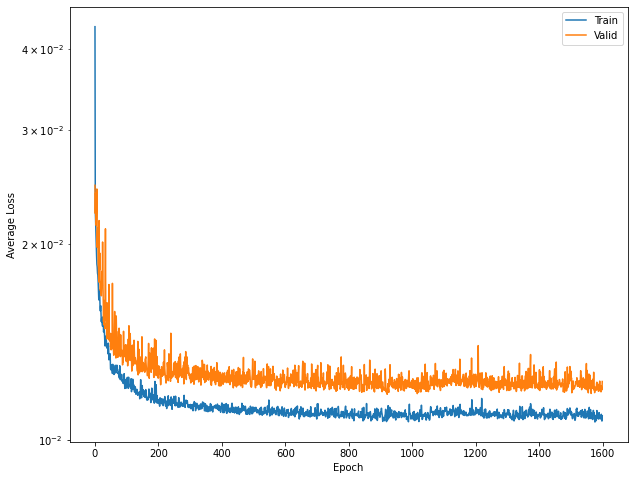

In [25]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [26]:
out_samples = []
for sample in mlp_test_dataset:
    img = sample[0]
    img = img.to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    model.eval()
    with torch.no_grad():
        out_label  = model(img)
    out_label = out_label.cpu().numpy()
    # print(enumerate(encoded_img))
    out_sample = {f"pred_label{i}": enc for i, enc in enumerate(out_label)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      out_sample[label_index] = label_val[i].numpy()
    out_samples.append(out_sample)
df_out_samples = pd.DataFrame(out_samples)
df_out_samples

,pred_label0,pred_label1,pred_label2,label0,label1,label2
0,0.068929,-0.360006,0.224785,0.0606,-0.488,0.30667
1,0.161912,-0.328957,0.081796,0.155,-0.249,0.14006
2,0.161961,-0.335647,0.063320,0.149,-0.236,0.11269
3,0.142878,-0.332634,0.114435,0.101,-0.58,0.10768
4,0.163003,0.297826,0.308128,0.173,0.471,0.47081
...,...,...,...,...,...,...
590,0.087882,0.445678,-0.280737,0.0867,0.512,-0.32221
591,0.075730,0.249275,0.324067,0.0665,0.312,0.41028
592,0.162912,-0.291569,0.289990,0.128,-0.42,0.35956
593,0.147005,-0.380501,-0.221686,0.117,-0.182,-0.03277


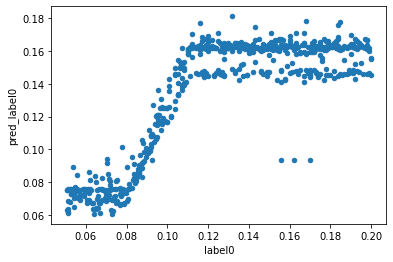

In [27]:
df_out_samples.plot(x ='label0', y='pred_label0', kind = 'scatter')
plt.show()

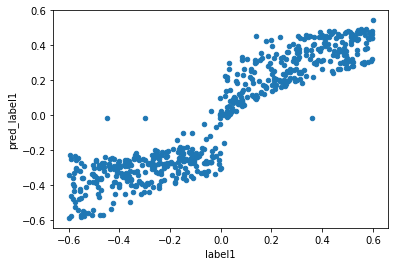

In [28]:
df_out_samples.plot(x ='label1', y='pred_label1', kind = 'scatter')
plt.show()

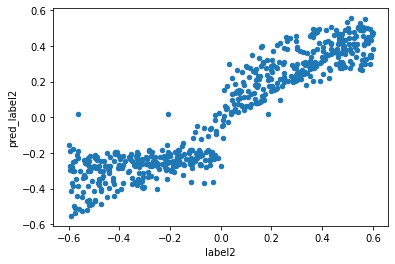

In [29]:
df_out_samples.plot(x ='label2', y='pred_label2', kind = 'scatter')
plt.show()

In [30]:
expt_arr_n = expt_arr[np.newaxis,:,:]
expt_arr_n.shape

(1, 2, 72)

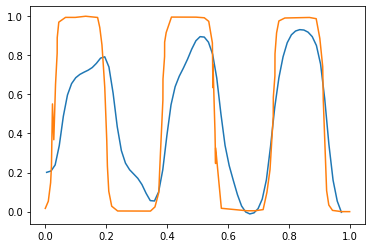

In [31]:
img = torch.from_numpy(expt_arr_n[0]).float()
img=torch.flatten(img).to(device)

encoder.eval().to(device)
decoder.eval().to(device)

with torch.no_grad():
  decoded_img = decoder(encoder(img))

plt.plot(decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1]) 
plt.plot(expt_arr_n[0][0],expt_arr_n[0][1])


In [33]:
model.eval().to(device)
with torch.no_grad():
  out_label  = model(encoder(img))

In [35]:
out_label = out_label.cpu().numpy()

In [37]:
out_label[0],out_label[1],out_label[2]

(0.14790773, -0.16863732, -0.42169204)